# Data Analysis

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as skpp
import imblearn.over_sampling as imbp
import sklearn.neighbors as skkn
import sklearn.metrics as skmt

# Read the data
df = pd.read_csv("employee_promotion_updated.csv")

# Clean the data
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Create a mapping dictionary for categorical variables
valueKeyMapping = dict()

def convert_to_numeric(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {unique_values[i]: i for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)
    
def convert_to_string(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {i: unique_values[i] for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)

for column in df.columns:
    if df[column].dtype == np.dtype("object"):
        unique_values = df[column].unique()
        valueKeyMapping[column] = unique_values

        convert_to_numeric(column, df)

    # Display descriptive statistics
print("Dataset Description:")
display(df.head())

Dataset Description:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,0,0,0,0,0,1,35,5.0,8,0,49.0,0
1,65141,1,1,1,1,1,1,30,5.0,4,0,60.0,0
2,7513,0,2,1,1,0,1,34,3.0,7,0,50.0,0
3,2542,0,3,1,1,1,2,39,1.0,10,0,50.0,0
4,48945,2,4,1,1,1,1,45,3.0,2,0,73.0,0


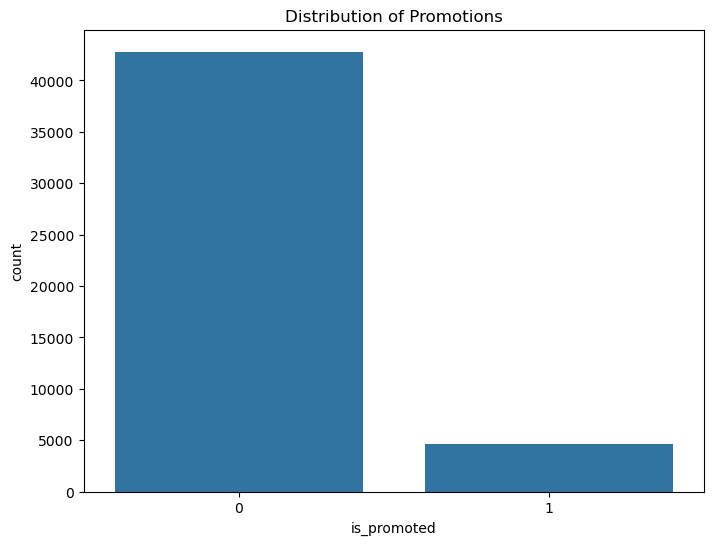

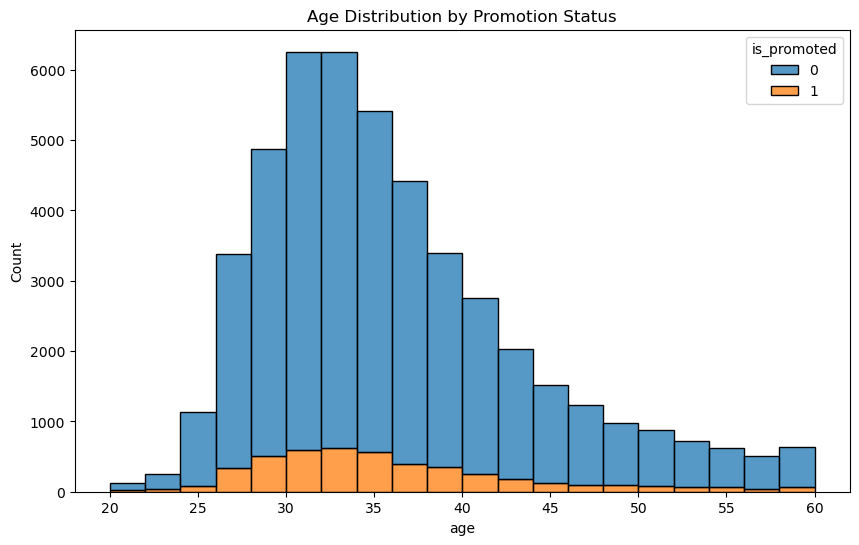

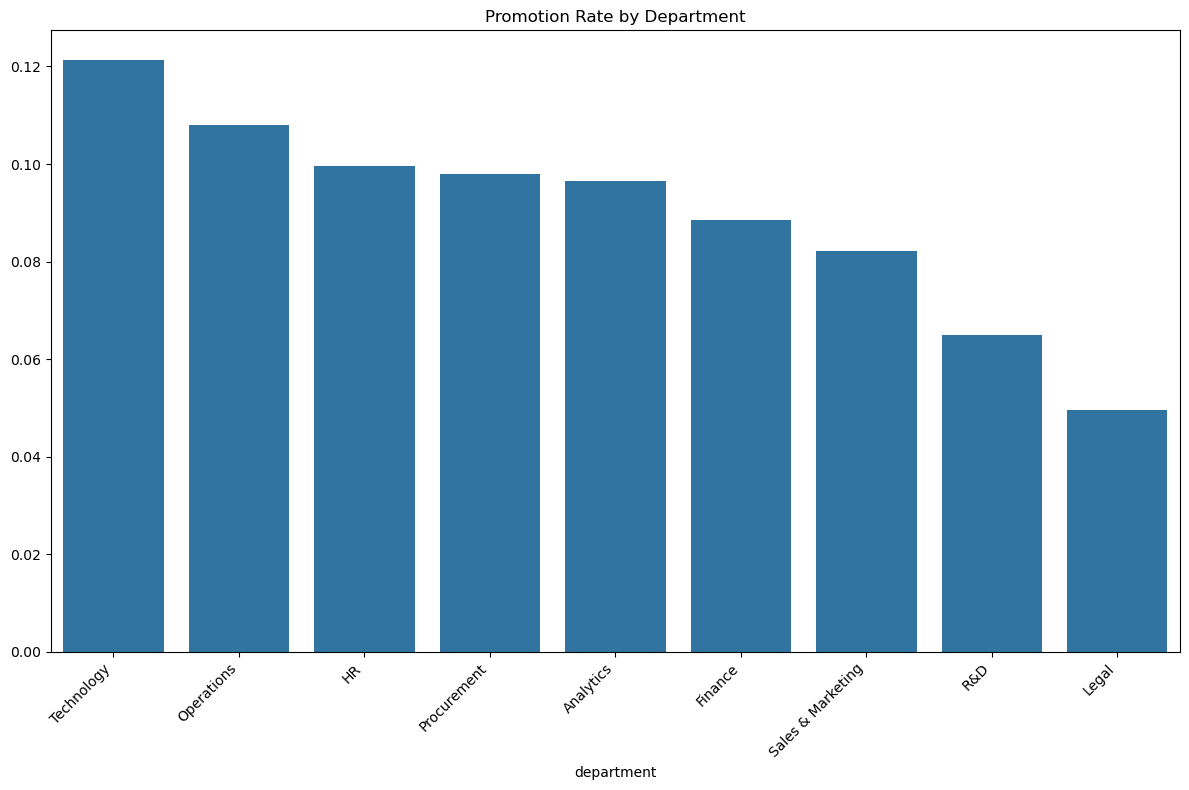

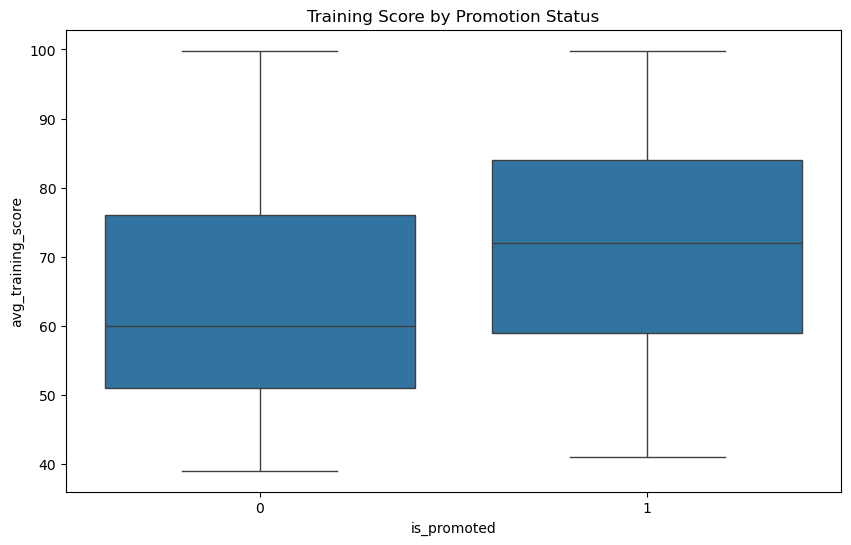

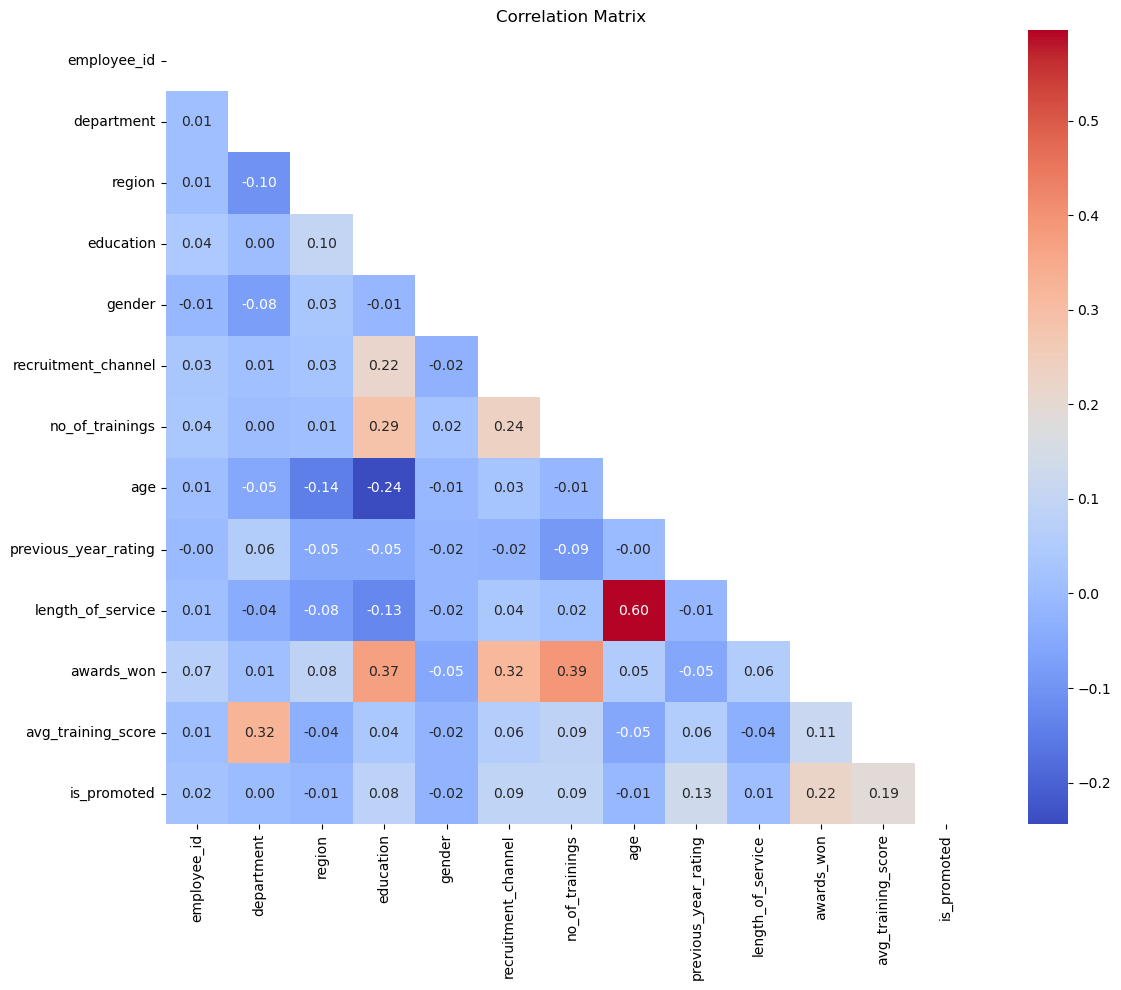

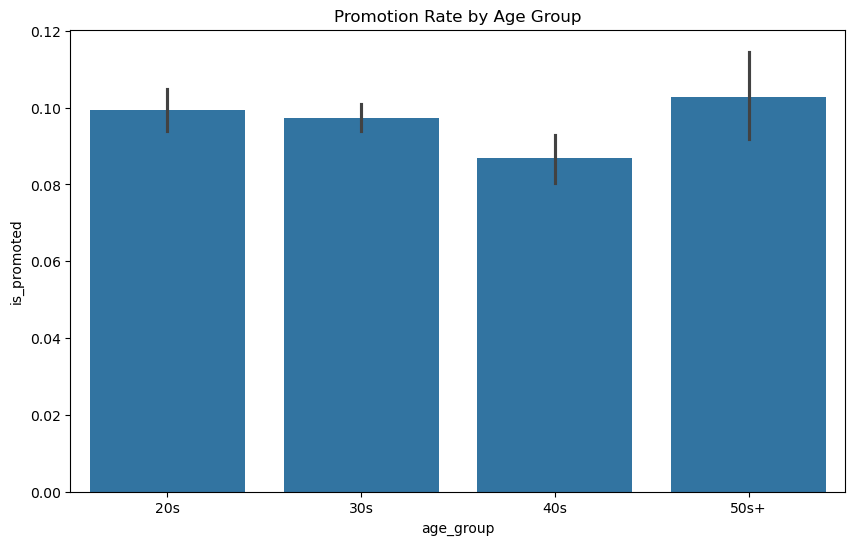

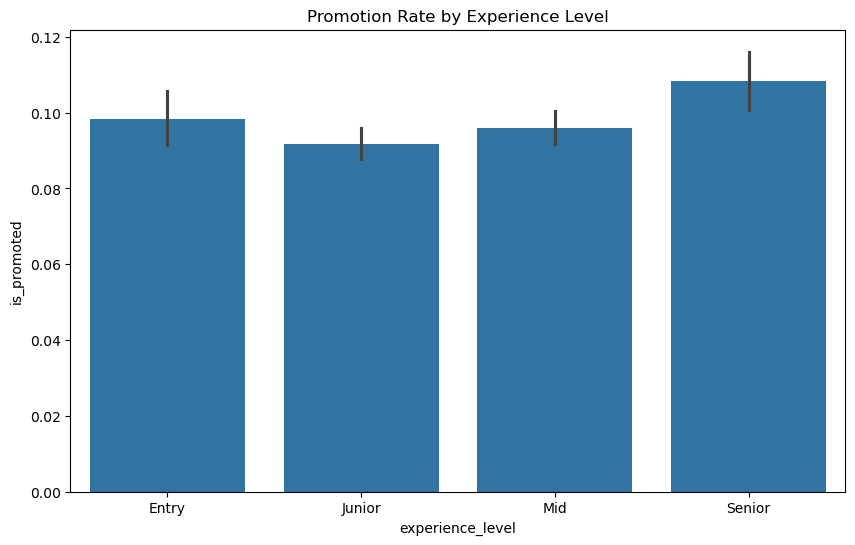

In [133]:
## Explanatory Data Analysis
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_promoted', data=df)
plt.title('Distribution of Promotions')
plt.show()

# Age distribution by promotion status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='is_promoted', multiple='stack', bins=20)
plt.title('Age Distribution by Promotion Status')
plt.show()

convert_to_string("department", df)
plt.figure(figsize=(12, 8))
dept_promotion = (
    df.groupby("department", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=dept_promotion.index, y=dept_promotion.values)
plt.title('Promotion Rate by Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

convert_to_numeric("department", df)

# Boxplot of training scores by promotion status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_promoted', y='avg_training_score', data=df)
plt.title('Training Score by Promotion Status')
plt.show()


# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

df_copy = df.copy()
# Create age groups
df_copy["age_group"] = pd.cut(
    df["age"], bins=[20, 30, 40, 50, 60], labels=["20s", "30s", "40s", "50s+"]
)

# Create experience level categories
df_copy["experience_level"] = pd.cut(
    df["length_of_service"],
    bins=[0, 2, 5, 10, 30],
    labels=["Entry", "Junior", "Mid", "Senior"],
)

# Analyze promotion rates by age group and experience level
plt.figure(figsize=(10, 6))
sns.barplot(x="age_group", y="is_promoted", data=df_copy)
plt.title('Promotion Rate by Age Group')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="experience_level", y="is_promoted", data=df_copy)
plt.title('Promotion Rate by Experience Level')
plt.show()

In [134]:
train, valid, test = np.split(
    df.sample(frac=1),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)

/home/diogo/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [135]:
def prepare_data(df, oversample=False):
    data = df[df.columns.difference(['is_promoted', 'employee_id'])].values
    target = df['is_promoted'].values
    
    scaler = skpp.StandardScaler()
    data = scaler.fit_transform(data)
    
    if oversample:
        ros = imbp.RandomOverSampler()
        data, target = ros.fit_resample(data, target)
    
    dataset = np.hstack((data, np.reshape(target, (-1, 1))))
    
    return dataset, data, target

In [136]:

train, train_features, train_target = prepare_data(train, oversample=True)
valid, valid_features, valid_target = prepare_data(valid)
test, test_features, test_target = prepare_data(test)

print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))
# Show proportion of promoted employees in the training target
print(
    "Proportion of promoted employees in training set:",
    np.mean(train_target == 1)
)


Training set size: 51410
Validation set size: 9476
Test set size: 9476
Proportion of promoted employees in training set: 0.5


In [146]:
knn_model = skkn.KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_target)
train_pred = knn_model.predict(valid_features)
print(skmt.classification_report(valid_target, train_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      8539
           1       0.24      0.47      0.31       937

    accuracy                           0.80      9476
   macro avg       0.58      0.65      0.60      9476
weighted avg       0.87      0.80      0.82      9476

